https://nbviewer.jupyter.org/github/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping/blob/master/K_Nearest_Neighbor_Dynamic_Time_Warping.ipynb

https://stats.stackexchange.com/questions/66027/time-series-classification-very-poor-results

https://github.com/markdregan/K-Nearest-Neighbors-with-Dynamic-Time-Warping


In [74]:
import sys
import collections
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import mode
from scipy.spatial.distance import squareform
from sklearn.metrics import classification_report, confusion_matrix
from utils.constants import MAX_SEQUENCE_LENGTH_LIST, NB_CLASSES_LIST

plt.style.use('bmh')
%matplotlib inline

In [75]:
class KnnDtw(object):
    """K-nearest neighbor classifier using dynamic time warping
    as the distance measure between pairs of time series arrays
    
    Arguments
    ---------
    n_neighbors : int, optional (default = 5)
        Number of neighbors to use by default for KNN
        
    max_warping_window : int, optional (default = infinity)
        Maximum warping window allowed by the DTW dynamic
        programming function
            
    subsample_step : int, optional (default = 1)
        Step size for the timeseries array. By setting subsample_step = 2,
        the timeseries length will be reduced by 50% because every second
        item is skipped. Implemented by x[:, ::subsample_step]
    """
    
    def __init__(self, n_neighbors=5, max_warping_window=10000, subsample_step=1):
        self.n_neighbors = n_neighbors
        self.max_warping_window = max_warping_window
        self.subsample_step = subsample_step
    
    def fit(self, x, l):
        """Fit the model using x as training data and l as class labels
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
            Training data set for input into KNN classifer
            
        l : array of shape [n_samples]
            Training labels for input into KNN classifier
        """
        
        self.x = x
        self.l = l
        
    def _dtw_distance(self, ts_a, ts_b, d = lambda x,y: abs(x-y)):
        """Returns the DTW similarity distance between two 2-D
        timeseries numpy arrays.

        Arguments
        ---------
        ts_a, ts_b : array of shape [n_samples, n_timepoints]
            Two arrays containing n_samples of timeseries data
            whose DTW distance between each sample of A and B
            will be compared
        
        d : DistanceMetric object (default = abs(x-y))
            the distance measure used for A_i - B_j in the
            DTW dynamic programming function
        
        Returns
        -------
        DTW distance between A and B
        """

        # Create cost matrix via broadcasting with large int
        ts_a, ts_b = np.array(ts_a), np.array(ts_b)
        M, N = len(ts_a), len(ts_b)
        cost = sys.maxsize * np.ones((M, N))

        # Initialize the first row and column
        cost[0, 0] = d(ts_a[0], ts_b[0])
        for i in range(1, M):
            cost[i, 0] = cost[i-1, 0] + d(ts_a[i], ts_b[0])

        for j in range(1, N):
            cost[0, j] = cost[0, j-1] + d(ts_a[0], ts_b[j])

        # Populate rest of cost matrix within window
        for i in range(1, M):
            for j in range(max(1, i - self.max_warping_window),
                            min(N, i + self.max_warping_window)):
                choices = cost[i - 1, j - 1], cost[i, j-1], cost[i-1, j]
                cost[i, j] = min(choices) + d(ts_a[i], ts_b[j])

        # Return DTW distance given window 
        return cost[-1, -1]
    
    def _dist_matrix(self, x, y):
        """Computes the M x N distance matrix between the training
        dataset and testing dataset (y) using the DTW distance measure
        
        Arguments
        ---------
        x : array of shape [n_samples, n_timepoints]
        
        y : array of shape [n_samples, n_timepoints]
        
        Returns
        -------
        Distance matrix between each item of x and y with
            shape [training_n_samples, testing_n_samples]
        """
        
        # Compute the distance matrix        
        dm_count = 0
        
        # Compute condensed distance matrix (upper triangle) of pairwise dtw distances
        # when x and y are the same array
        if(np.array_equal(x, y)):
            x_s = np.shape(x)
            dm = np.zeros((x_s[0] * (x_s[0] - 1)) // 2, dtype=np.double)
            
            # p = ProgressBar(shape(dm)[0])
            
            for i in range(0, x_s[0] - 1):
                for j in range(i + 1, x_s[0]):
                    dm[dm_count] = self._dtw_distance(x[i, ::self.subsample_step],
                                                      y[j, ::self.subsample_step])
                    
                    dm_count += 1
                    # p.animate(dm_count)
            
            # Convert to squareform
            dm = squareform(dm)
            return dm
        
        # Compute full distance matrix of dtw distnces between x and y
        else:
            x_s = np.shape(x)
            y_s = np.shape(y)
            dm = np.zeros((x_s[0], y_s[0])) 
            dm_size = x_s[0]*y_s[0]
            
            # p = ProgressBar(dm_size)
        
            for i in range(0, x_s[0]):
                for j in range(0, y_s[0]):
                    dm[i, j] = self._dtw_distance(x[i, ::self.subsample_step],
                                                  y[j, ::self.subsample_step])
                    # Update progress bar
                    dm_count += 1
                    # p.animate(dm_count)
        
            return dm
        
    def predict2(self, x):
        """Predict the class labels or probability estimates for 
        the provided data

        Arguments
        ---------
          x : array of shape [n_samples, n_timepoints]
              Array containing the testing data set to be classified
          
        Returns
        -------
          2 arrays representing:
              (1) the predicted class labels 
              (2) the knn label count probability
        """
        
        dm = self._dist_matrix(x, self.x)

        # Identify the k nearest neighbors
        knn_idx = dm.argsort()[:, :self.n_neighbors]

        # Identify k nearest labels
        knn_labels = self.l[knn_idx]
        
        # Model Label
        mode_data = mode(knn_labels, axis=1)
        mode_label = mode_data[0]
        mode_proba = mode_data[1]/self.n_neighbors

        return mode_label.ravel(), mode_proba.ravel()

In [76]:
prefix = 'Seawater'       ##### prefix = 'Seawater_4cats'
DATASET_INDEX = 8         ##### DATASET_INDEX = 9
gen = 0
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH_LIST[DATASET_INDEX]
NB_CLASS = NB_CLASSES_LIST[DATASET_INDEX]

aa = pd.read_csv('../data/{prefix}_TEST'.format(prefix=prefix), header=None)
len_aa = len(aa)
y_test = aa.iloc[:,0]
# y_test = label_binarize(aa_labels, classes=range(0, NB_CLASS))
X_test = np.array(aa.iloc[:,1:])

if gen == 0:
    aa = pd.read_csv('../data/{prefix}_TRAIN'.format(prefix=prefix), header=None)
elif gen == 1:
    aa = pd.read_csv('../data/{prefix}_EXP_TRAIN'.format(prefix=prefix), header=None)


len_aa = len(aa)
y_train = aa.iloc[:,0]
# y_test = label_binarize(aa_labels, classes=range(0, NB_CLASS))
X_train = np.array(aa.iloc[:,1:])

read_dictionary = np.load('../data/{prefix}_labels_dict.npy'.format(prefix=prefix)).item()
read_dictionary = {v: k for k, v in read_dictionary.items()}

y_train = np.array(y_train)
y_test = np.array(y_test)

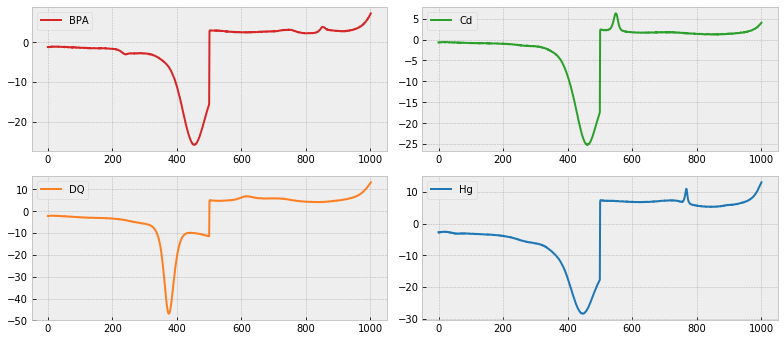

In [77]:
plt.figure(figsize=(11,7))
colors = ['#D62728','#2C9F2C','#FD7F23','#1F77B4','#9467BD', '#8C564A','#7F7F7F','#1FBECF','#E377C2','#BCBD27']

for i, r in enumerate([1, 8, 20, 32]):
    plt.subplot(3,2,i+1)
    plt.plot(X_train[r][:1010], label=labels[y_train[r]], color=colors[i], linewidth=2)
    plt.xlabel('')
    plt.legend(loc='upper left')
    plt.tight_layout()

In [78]:
m = KnnDtw(n_neighbors=1, max_warping_window=1) # 10
m.fit(X_train, y_train)                         #### m.fit(X_train[::10], y_train[::10])
label, proba = m.predict2(X_test)                #### label, proba = m.predict(X_test[::10])

In [79]:
label

array([ 0,  0,  5,  4,  5,  4,  6,  4,  6,  5,  1,  4,  1,  1,  1,  7,  7,
        7,  9,  7,  9,  9,  9,  1,  1,  1,  1,  1,  5,  2, 10,  2,  2, 10,
        2,  2,  2,  2,  7,  5,  7,  2,  2,  2,  7,  3,  3,  3,  3,  3,  3,
       10,  5,  5,  6,  1,  9,  5,  6,  1,  1,  7,  1,  2,  0,  5,  7,  7,
        9,  2,  4,  5,  6, 10,  9,  4,  1,  1,  9,  9,  2,  4,  4,  4, 10,
       10,  1,  5,  5,  1,  1,  4,  5,  5,  1,  5,  4,  5,  6,  7,  4,  5,
        5,  4,  1,  9,  1,  4,  4,  4,  2,  1,  5,  5,  6,  2,  2,  1,  5,
        5, 10, 10,  2,  6,  5,  5,  0,  5,  6, 10,  2,  2,  2,  5,  7,  6,
        6,  6,  7,  6,  0,  5,  2,  6,  6,  6,  6,  6,  6,  1,  1,  9,  1,
        6,  5,  6,  6,  9,  1,  5,  1,  5,  1, 10,  2,  0,  7,  0,  7,  5,
        6,  4,  4,  5,  1,  1,  0, 10,  1,  5,  7,  5,  7,  5,  5,  5,  7,
        7,  9,  7,  9,  1,  9,  9,  1,  9,  5,  1,  9,  9,  9,  9,  9,  9,
        9,  9,  1, 10,  8,  8,  8,  2,  7, 10, 10, 10, 10, 10,  2, 10, 10,
       10, 10, 10, 10, 10

             precision    recall  f1-score   support

        BPA       1.00      0.25      0.40         8
         Cd       0.35      0.25      0.29        36
         Cu       0.59      0.40      0.48        25
         DQ       1.00      1.00      1.00         6
        HMM       0.22      0.67      0.33        18
         Hg       0.25      0.08      0.12        39
        MeP       0.34      0.65      0.45        23
         NP       0.12      0.07      0.09        28
         PQ       1.00      0.67      0.80         3
         Pd       0.42      0.52      0.46        25
         SW       0.84      0.84      0.84        74

avg / total       0.50      0.48      0.46       285



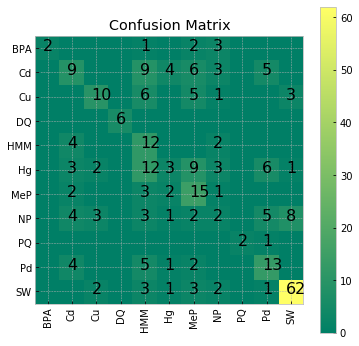

In [80]:
print(classification_report(label, y_test, target_names=[l for l in read_dictionary.values()]))

conf_mat = confusion_matrix(label, y_test)

fig = plt.figure(figsize=(6,6))
width = np.shape(conf_mat)[1]
height = np.shape(conf_mat)[0]

res = plt.imshow(np.array(conf_mat), cmap=plt.cm.summer, interpolation='nearest')
for i, row in enumerate(conf_mat):
    for j, c in enumerate(row):
        if c>0:
            plt.text(j-.2, i+.1, c, fontsize=16)
            
cb = fig.colorbar(res)
plt.title('Confusion Matrix')
_ = plt.xticks(range(NB_CLASS), [l for l in read_dictionary.values()], rotation=90)
_ = plt.yticks(range(NB_CLASS), [l for l in read_dictionary.values()])

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html